In [5]:
%matplotlib inline
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
import sys
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l

def get_data_ch7():  # 本函数已保存在d2lzh_tensorflow2包中方便以后使用
    data = np.genfromtxt('../../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return tf.convert_to_tensor(data[:1500, :-1],dtype=tf.float32), tf.convert_to_tensor(data[:1500, -1],dtype=tf.float32)

features,labels = get_data_ch7()
features.shape

TensorShape([1500, 5])

7.3.2. 从零开始实现

In [6]:
def sgd(params, states,hyperparams,grads):
    for i,p in enumerate(params):
        p.assign_sub(hyperparams['lr'] * grads[i])

“线性回归的从零开始实现”一节中已经实现过小批量随机梯度下降算法。我们在这里将它的输入参数变得更加通用，主要是为了方便本章后面介绍的其他优化算法也可以使用同样的输入。具体来说，我们添加了一个状态输入states并将超参数放在字典hyperparams里。此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法里的梯度不需要除以批量大小。

In [17]:
# 本函数已保存在d2lzh_tensprflow2包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    w = tf.Variable(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=tf.float32)
    b = tf.Variable(tf.zeros(1,dtype=tf.float32))


    def eval_loss():
        return np.array(tf.reduce_mean(loss(net(features, w, b), labels)))

    ls = [eval_loss()]
    data_iter = tf.data.Dataset.from_tensor_slices((features,labels)).batch(batch_size)
    data_iter = data_iter.shuffle(100)
  
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with tf.GradientTape() as tape:
                l = tf.reduce_mean(loss(net(X, w, b), y))  # 使用平均损失
                        
            grads = tape.gradient(l, [w,b])
            optimizer_fn([w, b], states, hyperparams,grads)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.246342, 0.013033 sec per epoch


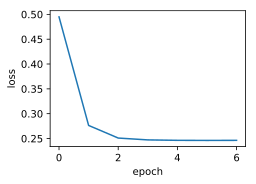

In [8]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.245398, 8.007673 sec per epoch


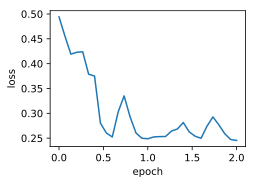

In [9]:
train_sgd(0.005, 1)

loss: 0.246043, 0.863296 sec per epoch


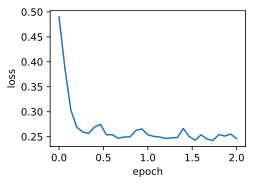

In [28]:
train_sgd(0.05, 10)

7.3.3. 简洁实现

同样，我们也无须自己实现小批量随机梯度下降算法。tensorflow.keras.optimizers 模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等。下面我们创建一个用于优化model 所有参数的优化器实例，并指定学习率为0.05的小批量随机梯度下降（SGD）为优化算法。

In [22]:
from tensorflow.keras import optimizers
trainer = optimizers.SGD(learning_rate=0.05)

In [25]:
# 本函数已保存在d2lzh_tensorflow2包中方便以后使用，事实上用不到trainer_hyperparams这个参数，这样写是为了和原书保持一致
def train_tensorflow2_ch7(trainer_name, trainer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1))
    
    loss = tf.losses.MeanSquaredError()

    def eval_loss():
        return np.array(tf.reduce_mean(loss(net(features), labels)))

    ls = [eval_loss()]
    data_iter = tf.data.Dataset.from_tensor_slices((features,labels)).batch(batch_size)
    data_iter = data_iter.shuffle(100)
 
    # 创建Trainer实例来迭代模型参数
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with tf.GradientTape() as tape:
                l = tf.reduce_mean(loss(net(X), y))  # 使用平均损失
                        
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.532480, 1.300436 sec per epoch


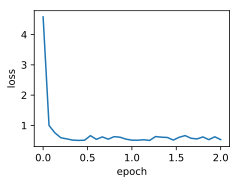

In [26]:
train_tensorflow2_ch7('trainer', {'learning_rate': 0.05}, features, labels, 10)